In [16]:
import pandas as pd
import plotnine as p9
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from sklearn.cluster import KMeans  # pour kmeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from mizani.formatters import percent_format
import seaborn as sns  # pour scatterplots

In [3]:
import requests

url = "https://raw.githubusercontent.com/linogaliana/python-datascientist/main/content/modelisation/get_data.py"
r = requests.get(url, allow_redirects=True)
open("getdata.py", "wb").write(r.content)

import getdata

votes = getdata.create_votes_dataframes()
votes.head(1)

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry,...,share_2008_democrat,share_2008_other,share_2008_republican,share_2012_democrat,share_2012_other,share_2012_republican,share_2016_democrat,share_2016_other,share_2016_republican,winner
0,29,227,00758566,0500000US29227,29227,Worth,06,690564983,493903,"POLYGON ((-94.63203 40.57176, -94.53388 40.570...",...,0.363714,0.034072,0.602215,0.325382,0.041031,0.633588,0.186424,0.041109,0.772467,republican


C:\Users\dmarin\AppData\Local\Programs\Python\Python311\Lib\site-packages\plotnine\ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
C:\Users\dmarin\AppData\Local\Programs\Python\Python311\Lib\site-packages\plotnine\ggplot.py:616: PlotnineWarning: Filename: img/featured_clustering.png


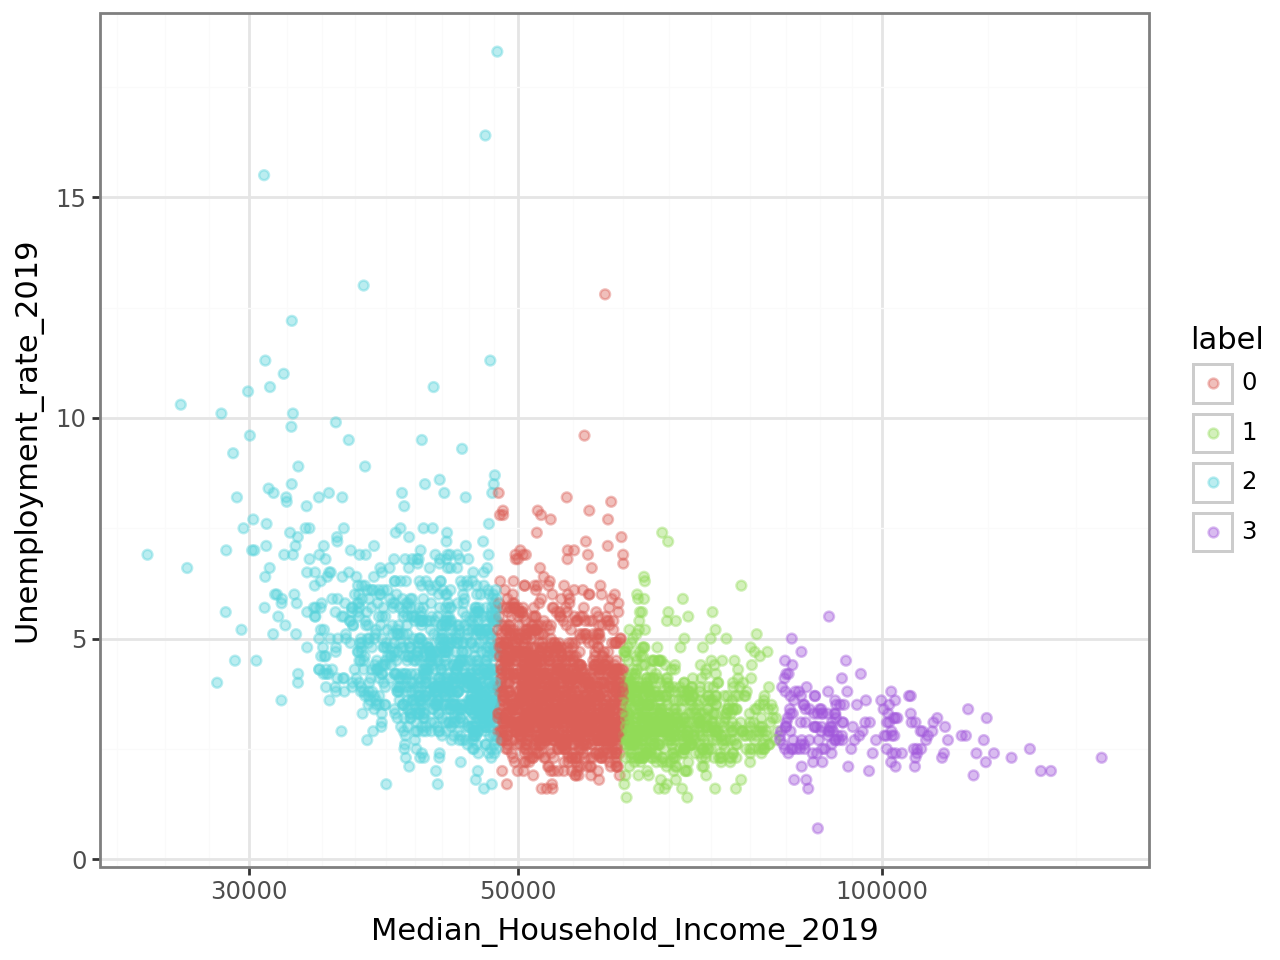

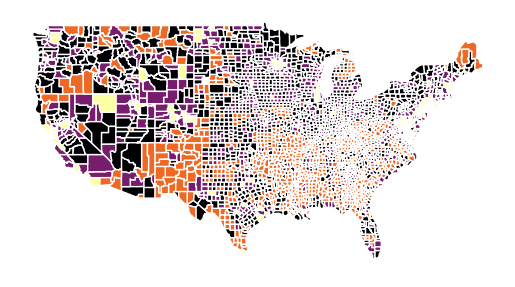

In [12]:
# # 1.1 Chargement de la base restreinte.
xvars = [
    "Unemployment_rate_2019",
    "Median_Household_Income_2019",
    "Percent of adults with less than a high school diploma, 2015-19",
    "Percent of adults with a bachelor's degree or higher, 2015-19",
]

df2 = votes[xvars + ["per_gop"]].dropna()

# 1.2. kmeans avec k=4
model = KMeans(n_clusters=4)
model.fit(df2[xvars])

# 1.3. Création de la variable label dans votes
votes["label"] = model.labels_
# votes['label'].head()

# 1.4. Carte de la typologie
p = votes.plot(column="label", cmap="inferno")
p.set_axis_off()

# 1.5. Nuage de points de 2 variables et coloration selon le label
votes["label"] = pd.Categorical(votes["label"])
p = (
    p9.ggplot(votes)
    + p9.geom_point(
        p9.aes(
            x="Median_Household_Income_2019", y="Unemployment_rate_2019", color="label"
        ),
        alpha=0.4,
    )
    + p9.theme_bw()
    + p9.scale_x_log10()
)

"""
==> La classification apparaît un peu trop nettement dans cette figure. Cela suggère que la variable de revenu (Median_Household_Income_2019) explique un peu trop bien le partitionnement produit par notre modèle pour que ce soit normal. C’est probablement le fait de la variance forte du revenu par rapport aux autres variables. Dans ce type de sitution, comme cela a été évoqué, il est recommandé de standardiser les variables.
"""
p9.ggsave(p, 'img/featured_clustering.png')
p


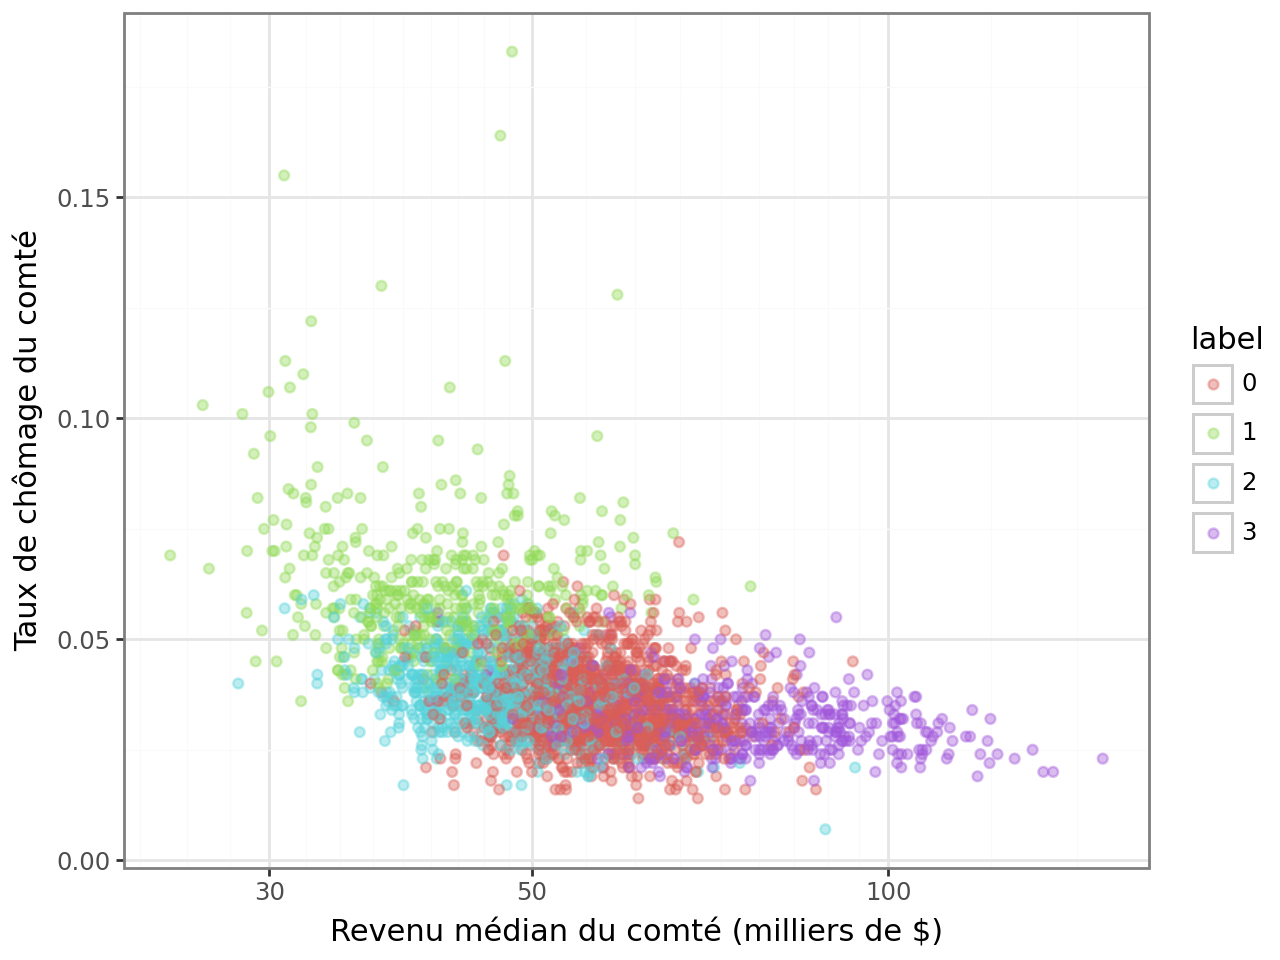

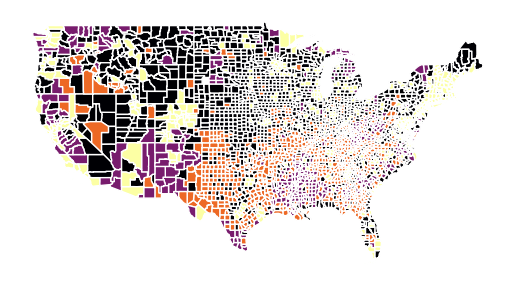

In [19]:
# # Exercice 1 avec standardisation des variables

kmeans = make_pipeline(StandardScaler(), KMeans(n_clusters=4, random_state=123))
kmeans.fit(df2)

votes["label"] = kmeans.predict(df2)

p = votes.plot(column="label", cmap="inferno")
p.set_axis_off()

votes["label"] = pd.Categorical(votes["label"])

"""
==> Nuage de points moins déterministe
"""
(
    p9.ggplot(votes)
    + p9.geom_point(
        p9.aes(
            x="Median_Household_Income_2019/1000",
            y="Unemployment_rate_2019/100",
            color="label",
        ),
        alpha=0.4,
    )
    + p9.theme_bw()
    + p9.scale_x_log10()
    # + p9.scale_y_continuous(labels=percent_format())
    + p9.labs(x="Revenu médian du comté (milliers de $)", y="Taux de chômage du comté")
)


C:\Users\dmarin\AppData\Local\Programs\Python\Python311\Lib\site-packages\plotnine\stats\stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 31'. Pick better value with 'binwidth'.


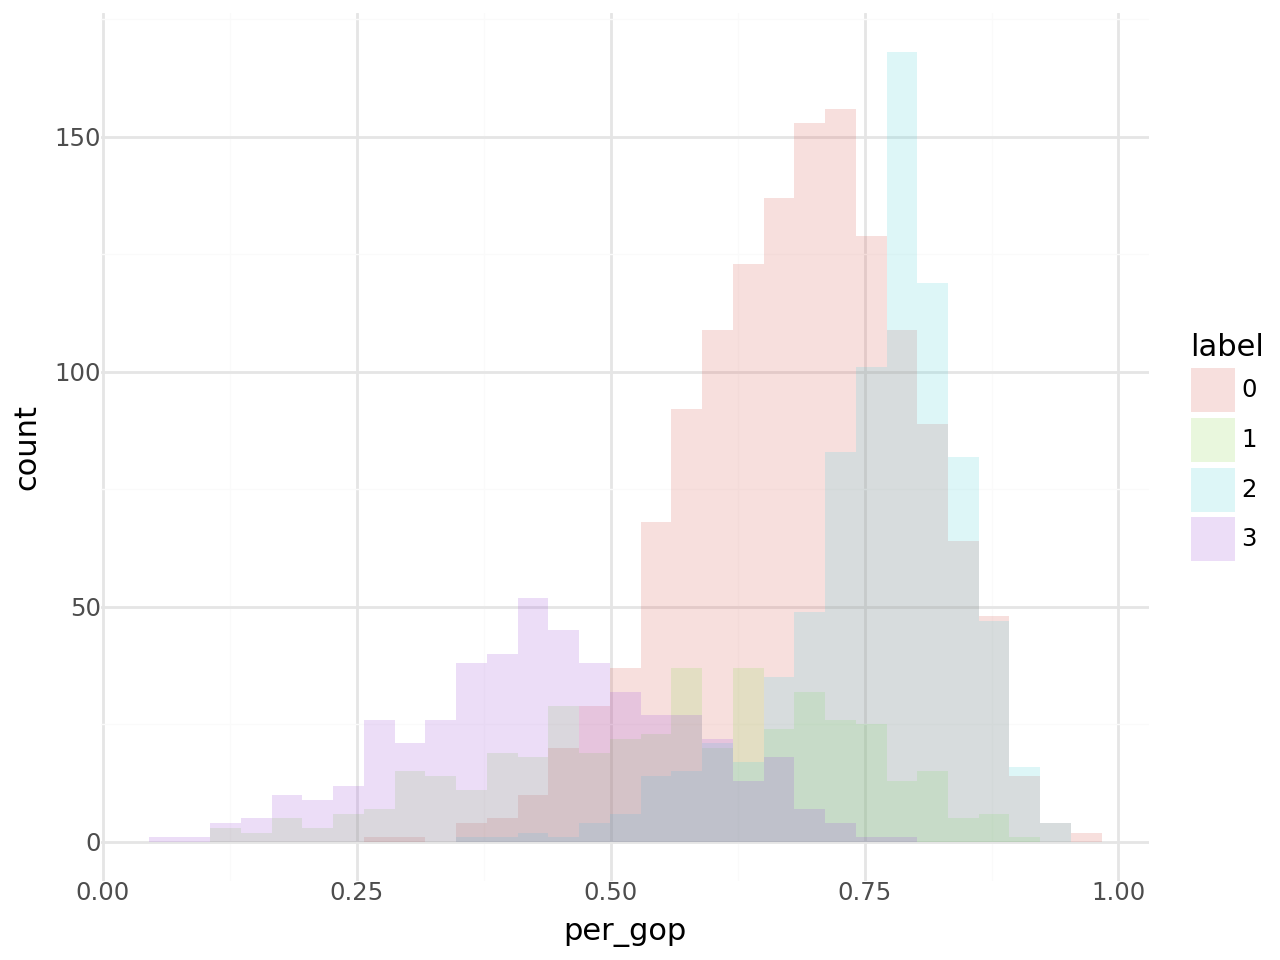

<Figure size 640x480 with 0 Axes>

In [20]:
# # 1.7 Distribution du vote pour chaque cluster:
plt.figure()
p2 = (
    p9.ggplot(votes)
    + p9.geom_histogram(p9.aes(x="per_gop", fill="label"), alpha=0.2, position="identity")
    + p9.theme_minimal()
)
p2

In [21]:
# # Scores de clustering
!pip install yellowbrick

     -------------------------------------- 282.6/282.6 kB 2.9 MB/s eta 0:00:00



[notice] A new release of pip available: 22.3.1 -> 24.3.1
[notice] To update, run: C:\Users\dmarin\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip


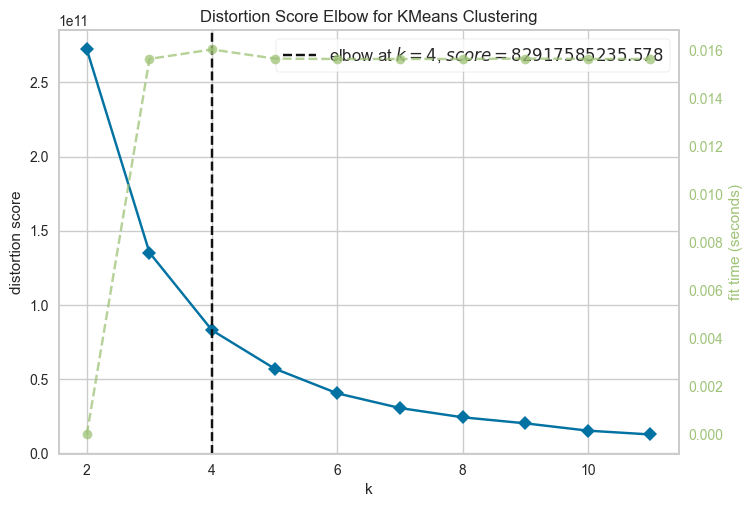

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [22]:
from yellowbrick.cluster import KElbowVisualizer

# # Visualisation du coude:
visualizer = KElbowVisualizer(model, k=(2, 12))
visualizer.fit(df2.loc[:, xvars])  # Fit the data to the visualizer
visualizer.show()

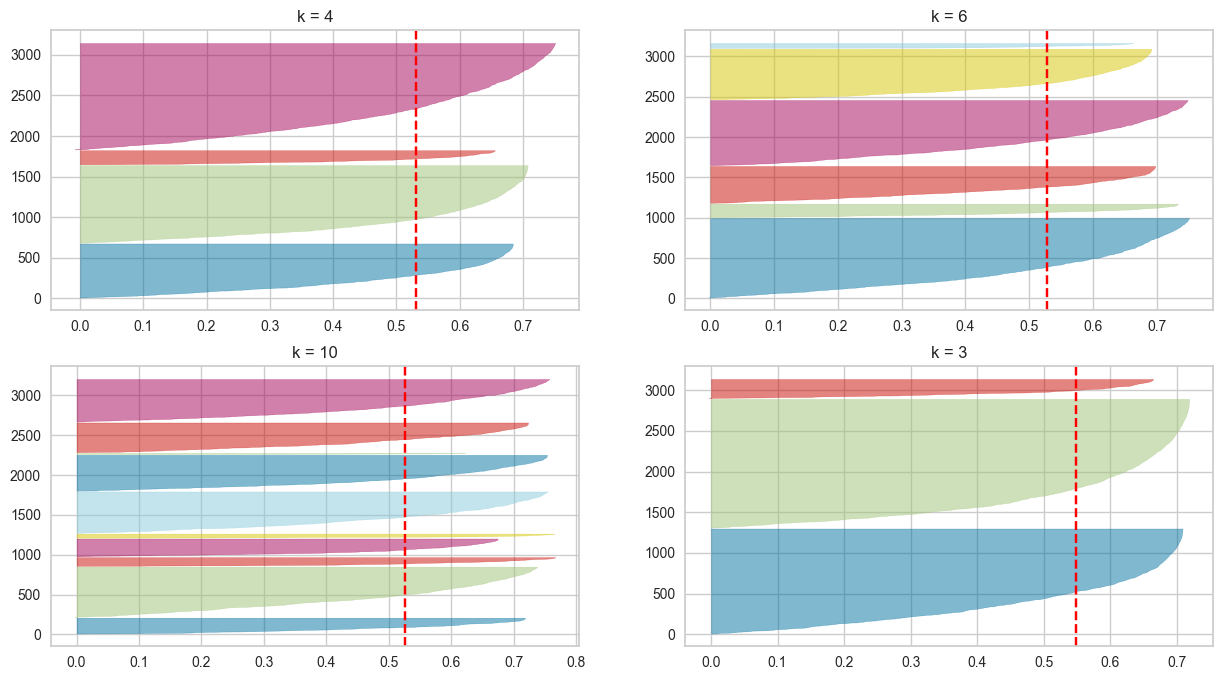

In [27]:
# # Visualisation du score de silhouette:
from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(2, 2, figsize=(15, 8))
j = 0
for i in [3, 4, 6, 10]:
    j += 1
    """
    Create KMeans instance for different number of clusters
    """
    km = KMeans(
        n_clusters=i, init="k-means++", n_init=10, max_iter=100, random_state=42
    )
    q, mod = divmod(j, 2)
    """
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    """
    visualizer = SilhouetteVisualizer(km, colors="yellowbrick", ax=ax[q - 1][mod])
    ax[q - 1][mod].set_title("k = " + str(i))
    visualizer.fit(df2[xvars])
    
fig.savefig('img/silhouette-yellowbrick.png')

Dimensions des données avant PCA : (3107, 4)
Dimensions des données après PCA : (3107, 2)
components:	[[-4.16490641e-05  9.99999862e-01 -2.23315106e-04  4.74024578e-04]
 [-2.16554059e-02 -5.23215995e-04 -4.94476555e-01  8.68921001e-01]]
variance expliquée par les 2 premières composantes:	[9.99999638e-01 2.52927770e-07]


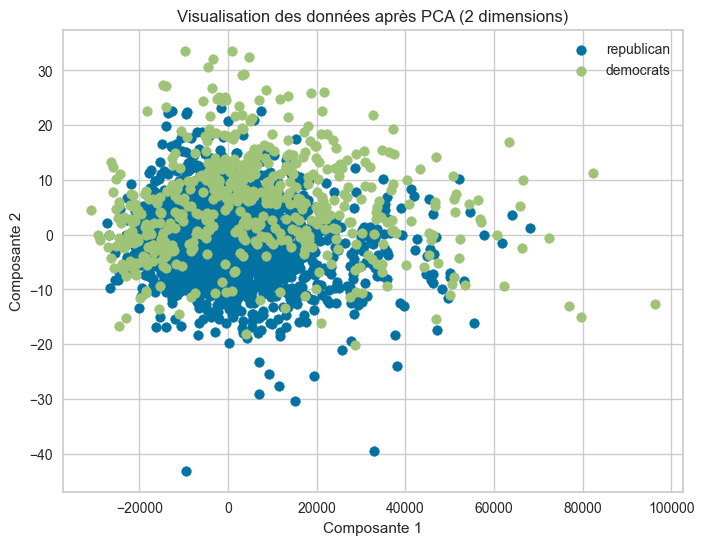

,Composante 1,Composante 2,classe
0,-10560.873563,5.295134,republican
1,-5924.874925,1.809664,republican
2,-5440.873517,4.020792,republican
3,-15133.877609,-1.519034,democrats
4,-13077.873577,5.620736,republican


In [64]:
# # 3. PCA analysis:
from sklearn.decomposition import PCA

X = df2.drop(['per_gop'], axis=1)
y = votes['winner']

print('Dimensions des données avant PCA : {}'.format(X.shape))

n_components = 2
pca = PCA(n_components=n_components)  # n_components entre 2 et le nombre de features (ici 5) 
x_2d = pca.fit_transform(X)
print('Dimensions des données après PCA : {}'.format(x_2d.shape))
print('components:\t{}'.format(pca.components_))
print('variance expliquée par les {} premières composantes:\t{}'.format(n_components, pca.explained_variance_ratio_))

# # ==> 99.9% de la variance associée au jeu de données est représenté par al 1ère composante 

# # Création d'un dataframe avec les données transformées:
columns=['Composante {}'.format(i) for i in range(1, n_components + 1)]
df_pca = pd.DataFrame(x_2d, columns=columns)
df_pca['classe'] = y


# # Visualiser les données PCA en 2D
plt.figure(figsize=(8, 6))
for classe in df_pca['classe'].unique():
    subset = df_pca[df_pca['classe'] == classe]
    plt.scatter(subset['Composante 1'], subset['Composante 2'], label=classe)

plt.title("Visualisation des données après PCA (2 dimensions)")
plt.xlabel("Composante 1")
plt.ylabel("Composante 2")
plt.legend()
plt.show()
df_pca.head()

In [46]:
# # Choisir la bonne dimension:
# # n_components = dimension souhaitée ou valeur entre 0 et 1 indiquant la proportion de la variance que l'on souhaite conserver:
pca = PCA(n_components=0.95)
x_2d = pca.fit_transform(X)
print('components:\t{}'.format(pca.components_))
print('variance ratio:\t{}'.format(pca.explained_variance_ratio_))

# # ==> une seule composante nécessaire



components:	[[-4.16490641e-05  9.99999862e-01 -2.23315106e-04  4.74024578e-04]]
variance ratio:	[0.99999964]
